<a href="https://colab.research.google.com/github/niels-overby/SRP2021/blob/main/SRP_STFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Velkommen til SRP øvelsen i Forbedring af talesignal ved brug af støjreduktion


Støjreduktion benyttes i høreapparate til at hjælpe personer med høreskader til at høre i omgivelser hvor der er forstyrrende støj elementer. I denne SRP øvelse introduceres gængse metoder.

I først del af denne øvelse vil vi starte med at introducer Google Colab som er det udviklingsmiljø vi skal arbejde med. Colab er et online programmerings miljø hvor almindelig tekst (som læses her) kan kombineres med Python kode og figurer.  


In [1]:
#@title Setup
#@markdown Tryk på pilen for at hente de nødvendige hjælpefilter og starte Colab serveren
!git clone https://github.com/niels-overby/SRP2021.git

%pip install soundfile

import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
import soundfile
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import os

import sys
sys.path.append('/content/SRP2021/')

from audiotools import utils, processing, spectrum


Cloning into 'SRP2021'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 78 (delta 20), reused 43 (delta 5), pack-reused 0
Unpacking objects: 100% (78/78), done.


# Del 1: Signaler i tid og frekvens

Lydsignaler kan aftegnes som bølgeformer, hvor svingninger vises over tid. En mikrofon opfanger for eksempelvis lydbølger der og laver dem om til elektriske signaler. 

I eksemplet nedenfor vises ordende "One", "Two", "Three" som bølgeformer. 


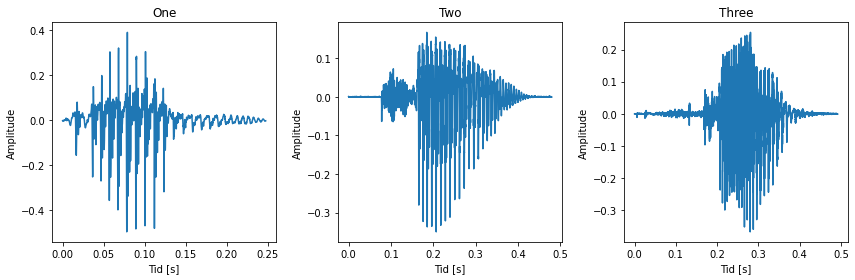

In [2]:
#@title 
audioDir = '/content/SRP2021/Audio/'
audioFiles = list(np.sort([f for f in os.listdir(audioDir) if 'lucas' in f]))

titles = ["One","Two","Three"]

plt.figure(figsize=(12,4))
for i in range(3):
  x, fs = utils.getAudio(audioDir + audioFiles[i+1])

  t = np.arange(len(x.T))/fs
  plt.subplot(1,3,i+1)
  plt.plot(t,x.T)
  plt.title(titles[i])
  plt.xlabel("Tid [s]")
  plt.ylabel("Amplitude")

  display(utils.play(x,fs))
plt.tight_layout()
plt.show()
  



* Beskriv hvad du ser
* Hvordan ser konsonanter ud i forhold til vokaler?

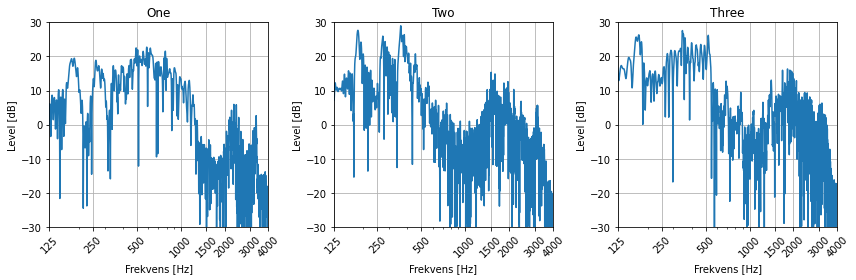

In [31]:
#@title Frekvensspektrum
audioDir = '/content/SRP2021/Audio/'
audioFiles = list(np.sort([f for f in os.listdir(audioDir) if 'lucas' in f]))

titles = ["One","Two","Three"]

fft = spectrum.FFT(N=44100,fs=fs)

plt.figure(figsize=(12,4))
for i in range(3):
  x, fs = utils.getAudio(audioDir + audioFiles[i+1])

  X = fft.transform(x)
  plt.subplot(1,3,i+1)
  plt.semilogx(fft.f,(20*np.log10(np.abs(X.T))))
  plt.title(titles[i])
  plt.ylabel("Level [dB]")
  plt.xlabel("Frekvens [Hz]")
  plt.xlim([200,4000])
  plt.xticks([125,250,500,1000,1500,2000,3000,4000],[125,250,500,1000,1500,2000,3000,4000],rotation=45)
  plt.ylim([-30,30])
  
  plt.grid()
plt.tight_layout()
plt.show()
  



Ved frekvensanalyse kan frekvenserne af et signal identificeres. Dette kan bruges til for eksempelvis at finde grundtonen af en lyd. I ovenstående figure kan det ses at det meste of frekvens indholdet for de tre ord er mellem 125 og 1000 Hz.

* Hvilke forskelle er der på de tre signaler?
* Både bølgeforme og frekvensspektre kan bruges til at analysere signaler, men hvad er de væsentligeste forskelle?

**We should use some other signals for the spectrum analysis**


## Spektrogrammet

En metode til at analysere et signal i både tid og frekvens er ved hjælp af spektrogrammet. Spektrogrammet består af at dele et tidssignal op i mindre stykker, kaldet rammer, hvor frekvensspektret beregnes i hver ramme. Ved at sætte rammerne op efterfulgt af hinanden kan frekvensindholdet over tid vises. Oftest vises dette ved at lade x-aksen være tids-aksen, y-aksen være frekvens aksen, mens farveintenstiteten viser lydniveauet for hver frekvens.



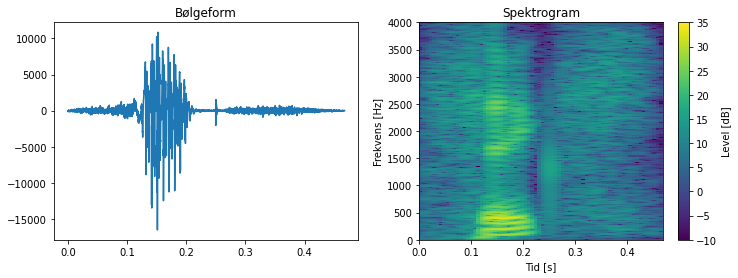

In [13]:
#@title Tal fra 0 til 9 {run: "auto"}

digit = "6" #@param ["0","1","2","3","4","5","6","7","8","9"]
digitFile = audioDir+audioFiles[int(digit)]

x,fs = utils.getAudio(digitFile)
x = processing.normalize().transform(x)
t = np.arange(len(x.T))/fs

stft = spectrum.STFT(fs=fs,nperseg=512,nfft=4,noverlapratio=0.9)
X = stft.transform(x)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(t,x.T)
plt.title("Bølgeform")

plt.subplot(122)
plt.pcolormesh(stft.t,stft.f,10*np.log10(np.abs(X[0])),vmin=-10,vmax=35)
plt.ylim([0,4e3])
plt.title("Spektrogram")
plt.ylabel("Frekvens [Hz]")
plt.xlabel("Tid [s]")
cbar = plt.colorbar()
cbar.set_label("Level [dB]")
plt.show()

display(utils.play(x,fs))

### STFT Ekstra øvelse: 
Spektrogrammet laves ved at opdele et signal i små stykker hvorefter disse stykker analyseres ved brug af fourier transformationen. Længden af disse stykker bestemmer præcisionen af spektrogrammet. Benyttes meget korte stykker bliver spektrogrammet meget præcist i forhold til tid, men mindre præcist i forhold til frekvens. Omvendt, hvis der bruges lange stykker bliver spektrogrammet meget præcist i frekvens, men mindre præcist i tid. Dette stykke kaldes en ramme, eller på engelsk: frame. 

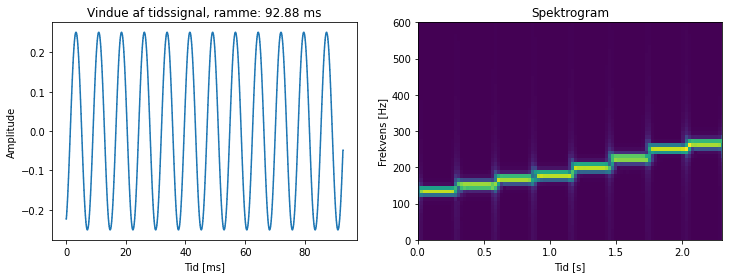

In [28]:
#@title Usikkerhed i tid og frekvens {run: "auto"}

audioDir = '/content/SRP2021/Audio/'
audioFiles = [f for f in os.listdir(audioDir) if f.endswith('wav')]

x,fs = utils.getAudio(audioDir + "sine_cScale.wav")
#x,fs = utils.getAudio(audioDir + "guitar_cScale.wav")
frameSize = "4096" #@param [128,256,512,1024,2048,4096,8192,16384]
frameSize = int(frameSize)

t = np.arange(frameSize)/fs

stft = spectrum.STFT(fs=fs,nperseg=frameSize,nfft=1)
X = stft.transform(x)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title(f"Vindue af tidssignal, ramme: {np.around(frameSize/fs * 1e3,2)} ms")
plt.plot(t*1e3,x[0,5000:5000+frameSize])
plt.ylabel("Amplitude")
plt.xlabel("Tid [ms]")

plt.subplot(122)
plt.pcolormesh(stft.t,stft.f,(np.abs(X[0])))
plt.ylim([0,600])
plt.xlim([0,2.3])
plt.title("Spektrogram")
plt.xlabel("Tid [s]")
plt.ylabel("Frekvens [Hz]")
plt.show()

* Hvilken lyd afbilledes der på spektrogrammet?
* Hvad sker der hvis der er for få samples i en ramme?
* Hvorfor forringes tidsopløseligheden hvis rammen indenholde for mange samples?

